## DeepONet: Allen-Cahn equation

- Code:
  - https://github.com/hl4220/Extended-Physics-Informed-Neural-Operator/blob/main/Anti-derivative/PI_deepOnet_two_step_training.ipynb

- Data:
  - https://github.com/camlab-ethz/AI_Science_Engineering/blob/main/datasets/AC_data_input.npy
  - https://github.com/camlab-ethz/AI_Science_Engineering/blob/main/datasets/AC_data_output.npy

- created: 2024.11.22

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)  # current gpu seed
torch.cuda.manual_seed_all(seed) # All gpu seed
torch.backends.cudnn.deterministic = True  # type: ignore
torch.backends.cudnn.benchmark = False  # True로 하면 gpu에 적합한 알고리즘을 선택함.

### Data

In [ ]:
## Data
# https://github.com/camlab-ethz/AI_Science_Engineering/blob/main/datasets/AC_data_input.npy
# https://github.com/camlab-ethz/AI_Science_Engineering/blob/main/datasets/AC_data_output.npy

x_data = np.load("data/AC_data_input.npy")
y_data = np.load("data/AC_data_output.npy")
print(">> Data: ", x_data.shape, y_data.shape)

x_data_np = x_data[..., 1]  # input functions
c_data_np = x_data[..., 0]  # grid coordinates
y_data_np = y_data          # output functions
print(">> Data: ", x_data_np.shape, c_data_np.shape, y_data.shape)

>> Data:  (1000, 1001, 2) (1000, 1001)
>> Data:  (1000, 1001) (1000, 1001) (1000, 1001)


In [3]:
## Dataloader
from torch.utils.data import TensorDataset, DataLoader

grid_size = 1001
n_train = 500
n_test = 100
batch_size = 32

x_train = torch.tensor(x_data_np[:n_train]).float()
c_train = torch.tensor(c_data_np[:n_train]).float()
y_train = torch.tensor(y_data_np[:n_train]).float()

x_test = torch.tensor(x_data_np[-n_test:]).float()
c_test = torch.tensor(c_data_np[-n_test:]).float()
y_test = torch.tensor(y_data_np[-n_test:]).float()

train_loader = DataLoader(TensorDataset(x_train, c_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test, c_test, y_test), batch_size=batch_size, shuffle=False)

x, c, y = next(iter(train_loader))
print(">> Batch: ", x.shape, c.shape, y.shape)

>> Batch:  torch.Size([32, 1001]) torch.Size([32, 1001]) torch.Size([32, 1001])


### Model

In [4]:
class MLP(nn.Module):
    def __init__(self, layer_sizes, activation=nn.ReLU(), final_activation=None):
        super().__init__()
        self.layer_sizes = layer_sizes
        self.depth = len(layer_sizes) - 1

        layers = []
        for i in range(self.depth - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            layers.append(activation)
        layers.append(nn.Linear(layer_sizes[-2], layer_sizes[-1]))
        if final_activation is not None:
            layers.append(final_activation)
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
    
class DeepOnetVanila(nn.Module):
    def __init__(self, branch_net, trunk_net):
        super().__init__()
        self.branch_net = branch_net
        self.trunk_net = trunk_net

    def forward(self, x, c):
        # x = x.unsqueeze(-1).repeat(1, 1, x.shape[1]).permute(0, 2, 1)
        x = x.unsqueeze(1).repeat(1, x.shape[1], 1)
        c = c.unsqueeze(-1)
        out_branch = self.branch_net(x)
        out_trunk = self.trunk_net(c)
        out = torch.sum(out_branch * out_trunk, axis=-1)
        return out

### Training

In [ ]:
# Training
n_epochs = 200
learning_rate = 1e-3

branch_net = MLP(layer_sizes=[grid_size, 64, 64, 64, 64, 64], 
                 activation=nn.ReLU())
trunk_net = MLP(layer_sizes=[1, 64, 64, 64, 64, 64], 
                activation=nn.Tanh(), final_activation=nn.Tanh())
model = DeepOnetVanila(branch_net, trunk_net).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

for epoch in range(1, n_epochs + 1):
    model.train()
    loss_mse = 0
    train_loss = 0
    for x, c, y in train_loader:
        x, c, y = x.to(device), c.to(device), y.to(device)
        y_pred = model(x, c)
        loss = loss_fn(y_pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, c, y in test_loader:
            x, c, y = x.to(device), c.to(device), y.to(device)
            y_pred = model(x,c)
            test_loss += loss_fn(y_pred, y).item()

    train_loss /= len(train_loader)
    test_loss /= len(test_loader)
    scheduler.step()

    if epoch % (n_epochs // 10) == 0:
        print(f"[{epoch:4d}/{n_epochs}] (lr: {scheduler.get_last_lr()[0]:.2e}) "
              f"train_loss: {train_loss:.2e} | test_loss: {test_loss:.2e}")

[  20/200] (lr: 1.00e-03) train_loss: 2.96e-01 | test_loss: 3.15e-01
[  40/200] (lr: 1.00e-03) train_loss: 1.72e-01 | test_loss: 1.86e-01
[  60/200] (lr: 5.00e-04) train_loss: 1.41e-01 | test_loss: 1.50e-01
[  80/200] (lr: 5.00e-04) train_loss: 1.19e-01 | test_loss: 1.21e-01
[ 100/200] (lr: 2.50e-04) train_loss: 6.93e-02 | test_loss: 8.21e-02
[ 120/200] (lr: 2.50e-04) train_loss: 6.11e-02 | test_loss: 7.28e-02
[ 140/200] (lr: 2.50e-04) train_loss: 4.59e-02 | test_loss: 5.72e-02
[ 160/200] (lr: 1.25e-04) train_loss: 3.50e-02 | test_loss: 4.57e-02
[ 180/200] (lr: 1.25e-04) train_loss: 3.28e-02 | test_loss: 4.39e-02
[ 200/200] (lr: 6.25e-05) train_loss: 3.10e-02 | test_loss: 4.21e-02


### Evaluation

(100, 1001) (100, 1001) (100, 1001) (100, 1001)


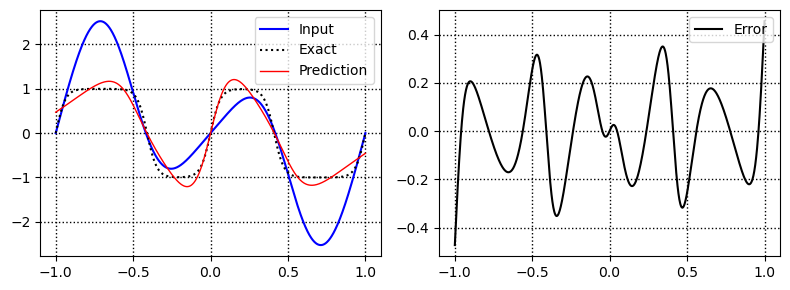

In [6]:
model.eval()
with torch.no_grad():
    x_test, c_test = x_test.to(device), c_test.to(device)
    y_pred = model(x_test, c_test)

x_test_np = x_test.cpu().detach().numpy()
c_test_np = c_test.cpu().detach().numpy()
y_test_np = y_test.cpu().detach().numpy()
y_pred_np = y_pred.cpu().detach().numpy()
print(x_test_np.shape, c_test_np.shape, y_test_np.shape, y_pred_np.shape)

idx = 10
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3))
ax1.plot(c_test_np[idx], x_test_np[idx], 'b', label="Input")
ax1.plot(c_test_np[idx], y_test_np[idx], 'k:', label="Exact")
ax1.plot(c_test_np[idx], y_pred_np[idx], 'r', lw=1, label="Prediction")
ax2.plot(c_test_np[idx], y_test_np[idx] - y_pred_np[idx], 'k', label="Error")

for ax in (ax1, ax2):
    ax.legend(loc="upper right")
    ax.grid(color='k', ls=':', lw=1)
fig.tight_layout()
plt.show()